# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [224]:
import os
from tqdm import tqdm, trange
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import random
import torchvision
import sklearn.metrics
import torch.nn.functional as F
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
from collections import defaultdict

In [225]:
# Можно использовать, но балл за соответствующие задания будет снижен.
import pytorch_metric_learning.distances
import pytorch_metric_learning.samplers
import pytorch_metric_learning.losses

In [356]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

#у меня макбук
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

In [357]:
set_random_seed(42)

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [358]:
set_random_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

!rm -rf data/training/.ipynb_checkpoints
!rm -rf data/testing/.ipynb_checkpoints


train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform)

Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

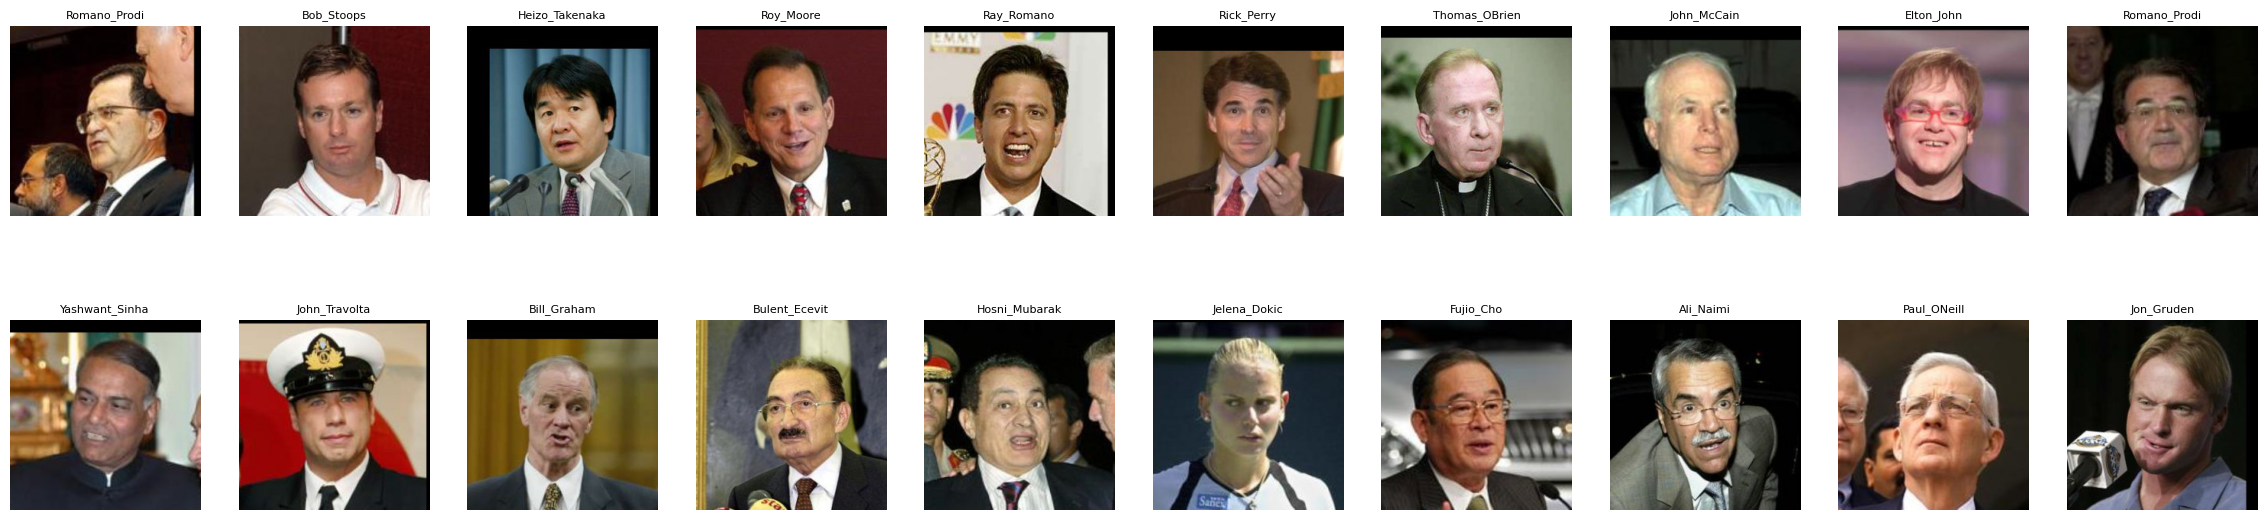

In [238]:
set_random_seed(42)

cols = 10
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
class_names = train_ds.classes

for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_ds))
        img, label = train_ds[random_index]
        label_name = class_names[label]
        
        ax = fig.add_subplot(rows, cols, j * cols + i + 1)
        ax.grid(False)
        ax.axis('off')

        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))

        ax.imshow(npimg)
        ax.set_title(label_name, fontsize=8)

plt.show()

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

In [359]:
set_random_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        transforms.Resize((128,128))
    ]
)
!rm -rf data/training/.ipynb_checkpoints
!rm -rf data/testing/.ipynb_checkpoints


train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform)

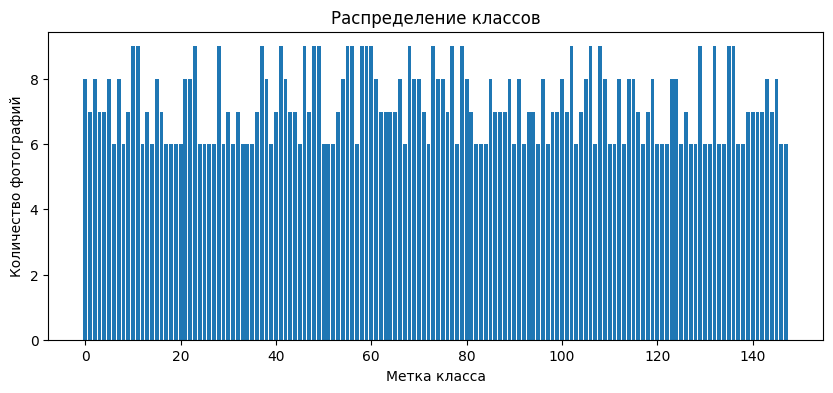

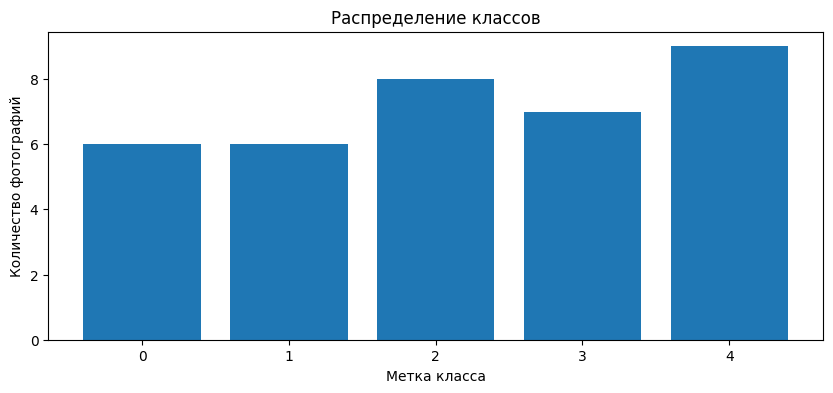

In [360]:
def show_class_distribtion(targets):

    targets = np.array(targets)
    classes, counts =np.unique(targets, return_counts=True)

    plt.figure(figsize=(10, 4))
    plt.bar(classes, counts)
    plt.xlabel("Метка класса")
    plt.ylabel("Количество фотографий")
    plt.title("Распределение классов")
    plt.show()

show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [361]:
set_random_seed(42)

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)
    
    def _idx2(self, idx):
        return idx // len(self.dataset)
    
    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)
    
train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████████████████████████████| 1296/1296 [00:00<00:00, 3602265.07it/s]


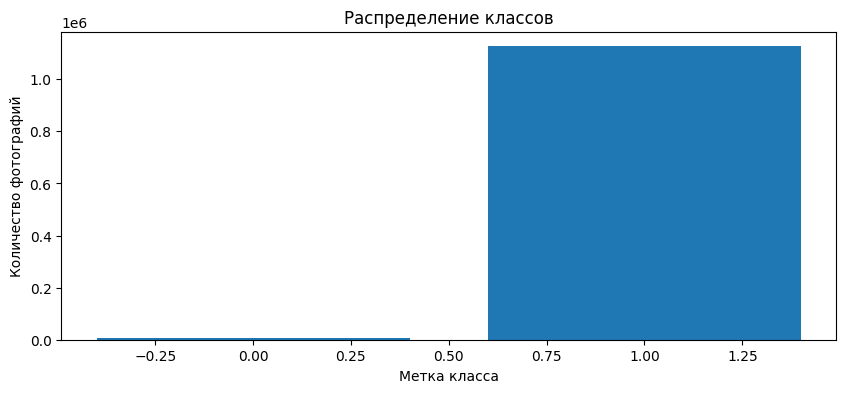

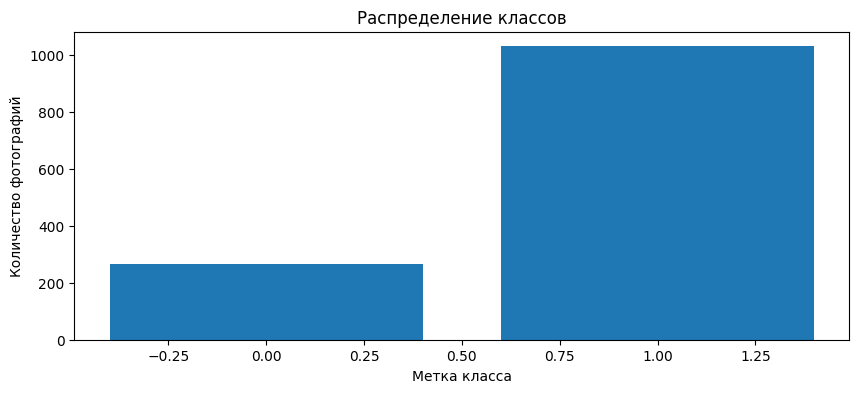

In [242]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [278]:
from torch.utils.data.sampler import Sampler
set_random_seed(42)

class MySampler(Sampler):
    def __init__(self, data, targets, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.targets = np.array(targets)
        
    def __iter__(self):
        zeros = np.where(self.targets == 0)[0]
        ones  = np.where(self.targets == 1)[0]
        
        self.min_len = min(len(zeros), len(ones))
        
        indices = []
        for i in range(self.min_len):
            indices.append(np.random.choice(zeros))
            indices.append(np.random.choice(ones))

        np.random.shuffle(indices)
        self.indices = indices

        return iter(indices)

    def __len__(self):
        return self.min_len * 2
        

train_pairs_sampler = MySampler(data=train_pairs, targets=train_pairs.targets, batch_size=32)

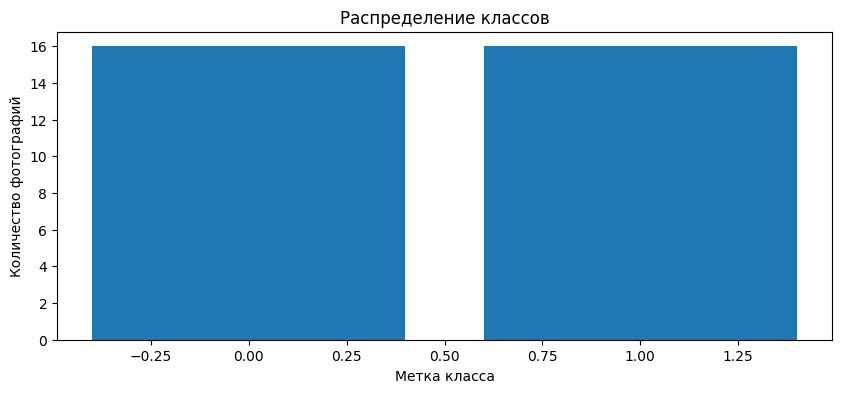

In [279]:
set_random_seed(42)

train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler, shuffle = False)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)


# Убедимся, что теперь выдача равномерная.
show_class_distribtion(next(iter(train_pairs_loader))[2])

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [280]:
set_random_seed(42)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + self.proj(x))

class ClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            ResidualBlock(128, 256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveMaxPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )

        self.fc = nn.Sequential(
            nn.Linear(4096, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1))


    def forward_once(self, x):
        x = self.cnn(x)
        return x

    def forward(self, image1, image2):

        output1 = self.forward_once(image1)
        output2 = self.forward_once(image2)
        diff1 = torch.abs(output1 - output2)
        diff2 = output1 * output2
        diff3 = torch.cat([output1, output2], dim=1)
        
        logits =  self.fc(torch.cat([diff1, diff2, diff3], dim=1)).squeeze(1)
        return logits
        
# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

In [281]:
set_random_seed(42)

model = ClassificationNet().to(device)

In [282]:
set_random_seed(42)

def train(model, optimizer, criterion, train_loader, epochs):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        epochs - number of training epochs
    """
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for image1, image2, labels in tqdm(train_loader, desc=f"Training, epoch {epoch+1}"):
            image1 = image1.to(device)
            image2 = image2.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            probs = model(image1, image2)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        epoch_train_loss = train_loss/len(train_loader)
        train_losses.append(epoch_train_loss)

        print(f'Эпоха: {epoch+1}, лосс на трейне: {epoch_train_loss}')
    

train(model=model, 
      optimizer=torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay = 1e-4), 
      criterion=nn.BCEWithLogitsLoss(), 
      train_loader=train_pairs_loader, 
      epochs=5)

Training, epoch 1: 100%|██████████████████████| 491/491 [07:59<00:00,  1.02it/s]


Эпоха: 1, лосс на трейне: 0.6508964953864422


Training, epoch 2: 100%|██████████████████████| 491/491 [08:29<00:00,  1.04s/it]


Эпоха: 2, лосс на трейне: 0.6238374611753553


Training, epoch 3: 100%|██████████████████████| 491/491 [09:41<00:00,  1.18s/it]


Эпоха: 3, лосс на трейне: 0.5966320911881394


Training, epoch 4: 100%|██████████████████████| 491/491 [08:16<00:00,  1.01s/it]


Эпоха: 4, лосс на трейне: 0.5727974055619444


Training, epoch 5: 100%|██████████████████████| 491/491 [07:26<00:00,  1.10it/s]


Эпоха: 5, лосс на трейне: 0.5470070982780573


In [283]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

print(get_auc_roc(model))
get_score(get_auc_roc(model))

100%|███████████████████████████████████████████| 21/21 [00:10<00:00,  1.96it/s]


0.8509380246733338


100%|███████████████████████████████████████████| 21/21 [00:06<00:00,  3.00it/s]


2.5

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

**Ответ:**

В процессе обучения сети я заметила, что как бы я ни меняла длину и ширину сверточного блока и гиперпараметры, сеть практически не обучается. Я начала смотреть свой конспект лекций и решила попробовать реализовать в своей сети остаточные связи, как в архитектуре ResNet. При написании кода я ориентировалась на различные статьи, ознакомиться с ними можно в списке ссылок в конце.

Также, я добавила к данным нормализацию (значения среднего и стандартного отклонения взяты из ноутбука с семинара 3) и ресайз для более быстрой работы.

Я пробовала обучать нейронку с обычным SGD и Adam, но качество получалось хуже, чем у AdamW. Также, изначально я пыталась обучать сеть с двумя сверточными слоями, но ее качество было недостаточным. Помогло также сделать слои шире, добавить дропаут, батч-нормализацию и weight_decay в AdamW. Я также пробовала разные длины шага, от 0.1 до 0.0001, но оптимальной оказалась 1e-3. Оптимальным значением dropout, который я добавила в полносвязный блок, оказалось 0.5 (я пробовала значения от 0.1 до 0.6).\
Мне кажется, что результаты могли получиться не очень хорошими, так как мы обучаем простую архитектуру на маленьком датасете - наверное, готовые предобученные модели справились бы лучше. Кроме того, мне кажется, что бинарная классификация не подходит под задачу - она заставляет модель однозначно определять, относятся ли фотографии к одному классу или нет, хотя в реальности степень сходства между фотографиями может лежать в промежутке от 0 до 1, но не равняться им. Из-за этого модель обучается очень "грубо", теряя информацию о возможных разных степенях сходства между фотографиями. Также, модель, обученная классифицировать пары изображений, не способна обобщаться на новые данные. Кроме того, из-за необходимости обрабатывать пары объектов модель обучается очень медленно.

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [362]:
set_random_seed(42)

class TripletLoss(nn.Module):
    def __init__(self, margin = 0.25, semi_hard=True):
        super().__init__()
        self.margin = margin
        self.semi_hard = semi_hard

    def forward(self, embeddings, labels):
        """
        На входе должно быть 2 параметра:
        - Набор эмбеддингов размера (batch_size, embedding_size)
        - Набор классов (номера людей, чьи это фотографии) размера (batch_size)
        """
        embeddings = embeddings.to(device)
        norm = (embeddings ** 2).sum(dim=1, keepdim=True)
        distances = torch.sqrt(torch.clamp(norm - 2 * embeddings @ embeddings.T + norm.T, min=1e-12))

        labels = labels.unsqueeze(1)
        mask_p = (labels == labels.T) # .T для попарных сравнений
        mask_n = (labels != labels.T)

        triplet_losses = []
        for i in range(embeddings.shape[0]):
            dist_p = distances[i][mask_p[i]]
            dist_n = distances[i][mask_n[i]]

            #чтобы не было нанов:
            if len(dist_p) == 0 or len(dist_n) == 0:
                continue

            losses = torch.clamp(dist_p.unsqueeze(1) - dist_n.unsqueeze(0) + self.margin, min=0)
            triplet_losses.append(losses.mean()) #вычисляем средний лосс для каждого анкора

        if len(triplet_losses) == 0:
            return torch.tensor(0.0, requires_grad=True).to(device)

        #semi-hard mining - усложняем для модели задачу: 
        if self.semi_hard:
            hardest_p = dist_p.max()
            semi_hard_n = dist_n[(dist_n > hardest_p) & (dist_n < hardest_p + self.margin)]
            if len(semi_hard_n) > 0:
                hardest_n = semi_hard_n.min()
            else:
                hardest_n = dist_n.min()
        else:
            hardest_p = dist_p.max()
            hardest_n = dist_n.min()

        loss = F.relu(hardest_p - hardest_n + self.margin)
        triplet_losses.append(loss)

        if len(triplet_losses) == 0:
            return torch.tensor(0.0, requires_grad=True, device=device)

        return torch.stack(triplet_losses).mean()


criterion = TripletLoss(margin = 0.25)

In [363]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])

assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

In [364]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.25, semi_hard=True):
        super().__init__()
        self.margin = margin
        self.semi_hard = semi_hard

    def forward(self, anchor, positive, negative):
        d_pos = F.pairwise_distance(anchor, positive, p=2)
        d_neg = F.pairwise_distance(anchor, negative, p=2)

        if self.semi_hard:
            # semi-hard mining
            mask = (d_neg > d_pos) & (d_neg < d_pos + self.margin)
            if mask.any():
                d_pos = d_pos[mask]
                d_neg = d_neg[mask]

        losses = F.relu(d_pos - d_neg + self.margin)
        return losses.mean()

criterion = TripletLoss(margin = 0.25)

#новый класс датасета:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = dataset.targets if hasattr(dataset, "targets") else [y for _, y in dataset]
        self.label_to_indices = {label: np.where(np.array(self.targets) == label)[0]
                                 for label in set(self.targets)}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]

        # positive
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.dataset[positive_index]

        # negative
        negative_label = random.choice(list(set(self.label_to_indices.keys()) - {anchor_label}))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]

        return (anchor_img, positive_img, negative_img), []

    def __len__(self):
        return len(self.dataset)

#новые даталоадеры:
train_triplets = TripletDataset(train_ds)
test_triplets = TripletDataset(test_ds)


train_triplets_loader = torch.utils.data.DataLoader(train_triplets, batch_size = 64, shuffle = True)
test_triplets_loader = torch.utils.data.DataLoader(test_triplets, batch_size = 64, shuffle = False, pin_memory=True)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        return self.relu2(out + self.proj(x))

#новая нейронка (модификация сиамской):
class TripletNet(torch.nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            ResidualBlock(128, 256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveMaxPool2d((1, 1)),

            nn.Flatten()
        )

        #нам теперь нужны эмбеддинги для триплет лосса
        self.embedding = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)
        return x

model = TripletNet(embedding_dim=128).to(device)


def train(model, optimizer, criterion, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (anchor, positive, negative), _ in tqdm(train_loader, desc=f"Training, epoch {epoch+1}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train(model=model, 
      optimizer=torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay = 1e-4),
      criterion=TripletLoss(margin = 0.25),
      train_loader=train_triplets_loader, 
      epochs=10)

Training, epoch 1: 100%|████████████████████████| 17/17 [01:47<00:00,  6.30s/it]


Epoch 1, Loss: 0.1318


Training, epoch 2: 100%|████████████████████████| 17/17 [02:33<00:00,  9.02s/it]


Epoch 2, Loss: 0.1262


Training, epoch 3: 100%|████████████████████████| 17/17 [02:03<00:00,  7.24s/it]


Epoch 3, Loss: 0.1340


Training, epoch 4: 100%|████████████████████████| 17/17 [01:47<00:00,  6.30s/it]


Epoch 4, Loss: 0.1230


Training, epoch 5: 100%|████████████████████████| 17/17 [01:42<00:00,  6.00s/it]


Epoch 5, Loss: 0.1235


Training, epoch 6: 100%|████████████████████████| 17/17 [01:36<00:00,  5.66s/it]


Epoch 6, Loss: 0.1255


Training, epoch 7: 100%|████████████████████████| 17/17 [01:30<00:00,  5.31s/it]


Epoch 7, Loss: 0.1294


Training, epoch 8: 100%|████████████████████████| 17/17 [01:33<00:00,  5.53s/it]


Epoch 8, Loss: 0.1243


Training, epoch 9: 100%|████████████████████████| 17/17 [01:37<00:00,  5.74s/it]


Epoch 9, Loss: 0.1257


Training, epoch 10: 100%|███████████████████████| 17/17 [00:58<00:00,  3.44s/it]

Epoch 10, Loss: 0.1398


In [365]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

print(get_auc_roc(model))
get_score(get_auc_roc(model))

100%|███████████████████████████████████████████| 21/21 [00:08<00:00,  2.36it/s]


0.8695817212935252


100%|███████████████████████████████████████████| 21/21 [00:08<00:00,  2.35it/s]


1.3916344258705027

Я переписала класс датасета, семплер и сделала новые даталоадеры под эту задачу. Также, я увеличила размер батча на трейне до 64, чтобы в батч попадало больше изображений одного класса. Кроме того, я немного переделала архитектуру сети, которую написала для части два: я оставила остаточные связи, но убрала рассчет расстояний и разниц между парами, а также полносвязные слои, так как тут для лосса нам нужны эмбеддинги. Сверточный блог остался тем же.
Я также добавила в сэмплер semi-hard mining, чтобы в выборку попадали более сложные примеры.

Также, я поменяла под саму сеть триплет лосс так, чтобы он сразу работал с анкорами, позитивами и негативами, потому что мне так удобнее; но я оставила версию с лейблами и эмбеддингами для ассерта.
Триплет-сеть работает намного быстрее, чем сиамская, так как нам больше не нужно рассматривать все пары объектов в датасете.

Я перебрала значения длины шага [1e-4, 3e-4, 1e-3], лучше всего себя показала 3e-4. Также, я попробовала поменять значения маржин лосс на 0.2 и 0.3, но аук-рок также упал в обоих случаях. Убрать weight_decay тоже не помогло.\
Я пробовала увеличивать число эпох, но свыше 10 эпох кажется избыточным.\
Мне кажется, что можно было бы попробовать еще увеличить размер батча, но к сожалению, на это у меня уже нет времени:(

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [366]:
from PIL import Image

my_img_path = "me.jpg"


In [367]:
set_random_seed(42)

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # как при обучении
    transforms.ToTensor(),
])

!rm -rf data/training/.ipynb_checkpoints
!rm -rf data/testing/.ipynb_checkpoints


train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform)

pil_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def get_embedding(model, img, device):
    model.eval()
    with torch.no_grad():
        if isinstance(img, Image.Image):
            img_tensor = pil_transform(img).unsqueeze(0).to(device)
        elif isinstance(img, torch.Tensor):
            img_tensor = img.unsqueeze(0).to(device)
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")
        emb = model(img_tensor)
    return emb.cpu()

def compute_dataset_embeddings(model, dataset, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for img, label in dataset:
            emb = get_embedding(model, img, device)
            embeddings.append(emb)
            labels.append(label)

    embeddings = torch.cat(embeddings)
    labels = torch.tensor(labels)
    return embeddings, labels


def find_top_n_similar_names(model, my_img_path, celebrity_embeddings, celebrity_labels, label_to_name, device, top_n=5):
    my_emb = get_embedding(model, Image.open(my_img_path).convert("RGB"), device)
    similarities = F.cosine_similarity(my_emb, celebrity_embeddings)
    top_sim, top_idx = torch.topk(similarities, top_n)
    results = [(label_to_name[celebrity_labels[idx].item()], top_sim[i].item()) for i, idx in enumerate(top_idx)]
    return results


def visualize_top_matches(my_img_path, top_matches, celeb_dataset, label_to_name):
    fig, axes = plt.subplots(1, len(top_matches)+1, figsize=(4*(len(top_matches)+1), 4))

    img = Image.open(my_img_path).convert("RGB")
    axes[0].imshow(img)
    axes[0].set_title("Your photo")
    axes[0].axis("off")

    for i, (name, _) in enumerate(top_matches):
        label = [k for k,v in label_to_name.items() if v==name][0]
        for img_ds, lbl in celeb_dataset:
            if lbl == label:
                if isinstance(img_ds, torch.Tensor):
                    img_ds = img_ds.permute(1,2,0).numpy()
                axes[i+1].imshow(img_ds)
                axes[i+1].set_title(name)
                axes[i+1].axis("off")
                break

    plt.show()

label_to_name = inverted_dict = {value: key for key, value in train_ds.class_to_idx.items()}

celebrity_embeddings, celebrity_labels = compute_dataset_embeddings(model, train_ds, device)

Топ-5 наиболее похожих людей:
Angela_Bassett, сходство: 0.9505
Yao_Ming, сходство: 0.9503
Vaclav_Havel, сходство: 0.9375
Roman_Polanski, сходство: 0.9143
Kim_Dae-jung, сходство: 0.9124


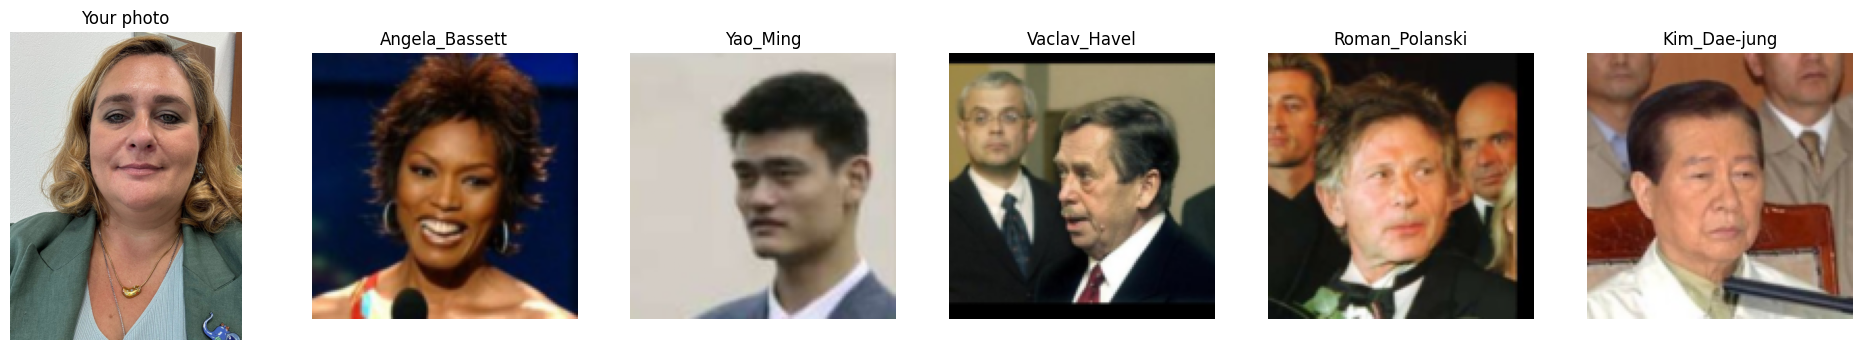

In [371]:
top_matches = find_top_n_similar_names(model, "mum.jpg", celebrity_embeddings, celebrity_labels, label_to_name, device, top_n=5)

print("Топ-5 наиболее похожих людей:")
for name, sim in top_matches:
    print(f"{name}, сходство: {sim:.4f}")

visualize_top_matches("mum.jpg", top_matches, train_ds, label_to_name)

Топ-5 наиболее похожих людей:
Robert_Redford, сходство: 0.9833
Al_Sharpton, сходство: 0.9799
Mariah_Carey, сходство: 0.9709
Tommy_Haas, сходство: 0.9704
Sylvester_Stallone, сходство: 0.9669


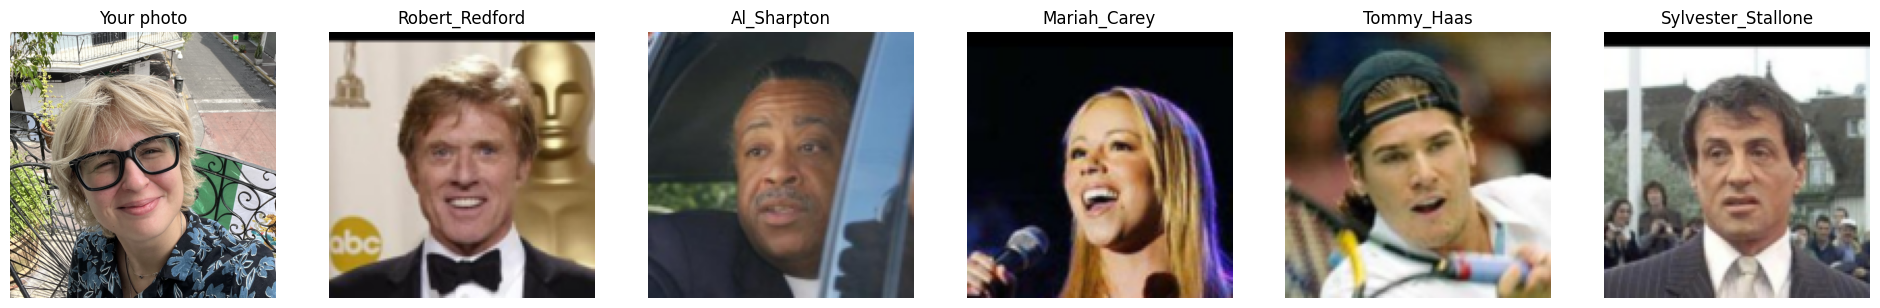

In [372]:
top_matches = find_top_n_similar_names(model, "me.jpg", celebrity_embeddings, celebrity_labels, label_to_name, device, top_n=5)

print("Топ-5 наиболее похожих людей:")
for name, sim in top_matches:
    print(f"{name}, сходство: {sim:.4f}")

visualize_top_matches("me.jpg", top_matches, train_ds, label_to_name)

Топ-5 наиболее похожих людей:
Justine_Pasek, сходство: 0.9866
Paul_Martin, сходство: 0.9859
Natalie_Coughlin, сходство: 0.9837
Elton_John, сходство: 0.9826
Yao_Ming, сходство: 0.9802


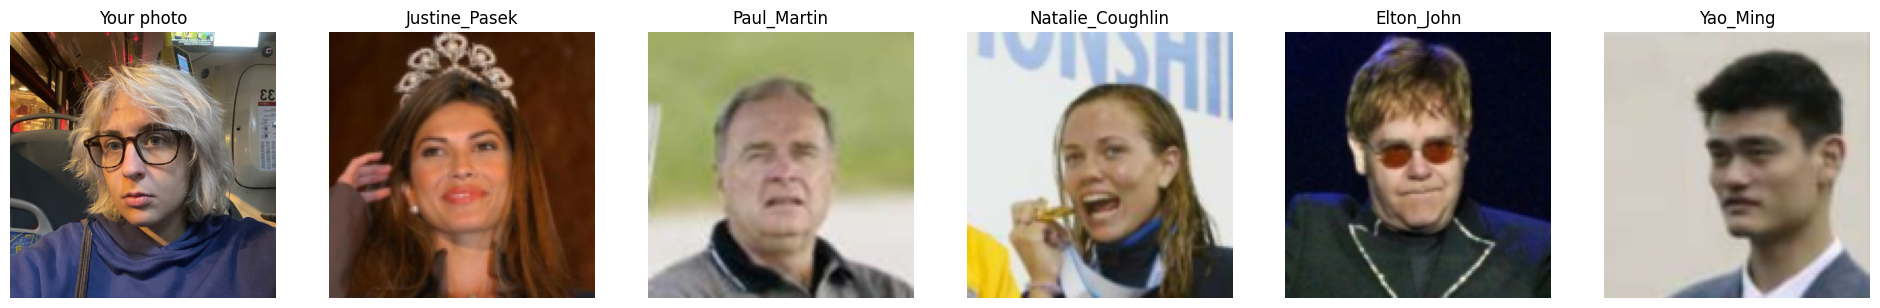

In [373]:
top_matches = find_top_n_similar_names(model, "me_2.jpg", celebrity_embeddings, celebrity_labels, label_to_name, device, top_n=5)

print("Топ-5 наиболее похожих людей:")
for name, sim in top_matches:
    print(f"{name}, сходство: {sim:.4f}")

visualize_top_matches("me_2.jpg", top_matches, train_ds, label_to_name)

### References:

https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler

https://medium.com/@haleema.ramzan/how-to-build-a-custom-batch-sampler-in-pytorch-ce04161583ee

https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.BatchSampler

https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.pooling.AdaptiveMaxPool2d.html

https://www.geeksforgeeks.org/python/enumerate-in-python/

https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/

https://liberiangeek.net/2023/12/calculate-triplet-loss-pytorch/

https://medium.com/@ultimateabhi/face-recognition-with-siamese-networks-using-resnet-50-7831c44e404a

https://github.com/shaySitri/LFW-Siamese

https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c

https://d2l.ai/chapter_convolutional-modern/resnet.html

https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed

https://habr.com/ru/articles/737060/

https://medium.com/@rjnclarke/fine-tune-an-embedding-model-with-triplet-margin-loss-in-pytorch-62bf00865a6c

также, для сверточного блока ноутбук с третьего семинара, для функции трейн - мое же первое дз, для третьей части - лекция 6